In [5]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import colorsys
from scipy import optimize

plt.style.use('ggplot')

In [6]:
chain = r.TChain("farline/eventTree")
chain.Add("./9day/gm2offline_ana_233128_16528.00035.root")
chain.Add("./9day/gm2offline_ana_233130_16535.00353.root")
chain.Add("./9day/gm2offline_ana_233134_16482.00307.root")
chain.Add("./9day/gm2offline_ana_233136_16528.00161.root")

1

In [7]:
def create_hist(t_chain, hist_name, Xbins, energy_min, energy_max, caloNum):
    """
    Creates a TH2D histogram of y vs time between 0 and 700 μs
    
    chain: [TChain] the data
    hist_name: [str] what to call the histogram
    Xbins: [int] the number of bins that should be used on the time axis
    energy_min: [int] the minimum energy threshhold
    energy_max: [int] the maximum energy threshhold
    """
    hist = r.TH2D(hist_name, "y vs time; Time[#mus]; Y", Xbins, 0,700, 600,0,6)
    t_chain.Draw("y:time*1.25/1000.>>"+hist_name,
               "energy<"+str(energy_max)+"&& energy >"+str(energy_min)+"&& caloNum == "+str(caloNum),
               "goff")
    
    return hist

In [9]:
"""
create single histogram with all calorimeters, but no offsets or anything,
just ram it all together at matching times.
"""

Xbins = 1400
energy_min = 0
energy_max = 6000

hist = r.TH2D("all_calos", "y vs time; Time[#mus]; Y", Xbins, 0,700, 600,0,6)

chain.Draw("y:time*1.25/1000.>>all_calos", "energy<"+str(energy_max)+"&& energy >"+str(energy_min), "goff")

185534104

 - energy cuts
 - error bars
 - fit slopes

In [ ]:
"""
Create a list of histograms for easy access instead of having to wait
thirty years for them to be made every time you want to rename a plot
or whatever
"""

XBins = 1400
energy_min = 0    #1700
energy_max = 6000    #2900

# one histogram per calorimeter
calo_hists = []
for i in range(1, 25):
    print('starting ' + str(i))
    calo_hists.append(create_hist(chain, "h"+str(i), XBins,
                                  energy_min, energy_max, i))
    print('finished ' + str(i))

In [11]:
def plot_fit_results(data, fig_name):
    """
    Plots the fit results for a dataframe with columns:
    ['TimeBin', 'GausConst', 'GausMean', 'GausSD', 'ChiSquare', 'HistMean',
    'HistSD', 'Npoints', 'GausConst_ns', 'GausMean_ns', 'GausSD_ns', 'ChiSquare_ns']
    Saves plot in png fig_name.png
    
    data: [DataFrame] a pandas dataframe with the stuff to plot
    fig_name: [str] the desred name of the figure
    """
    mean_mean = data[(data['TimeBin'] < 400) & (data['TimeBin'] > 50)]['GausMean'].mean()
    mean_mean_ns = data[(data['TimeBin'] < 400) & (data['TimeBin'] > 50)]['GausMean_ns'].mean()
    
    fig, ax = plt.subplots(2, 5)
    fig.set_size_inches(27, 11)

    # --------------------------
    # with the spikes
    # --------------------------
    
    # mean
    
    ax[0, 0].plot(data['TimeBin'], data['GausMean'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[0, 0].plot(data['TimeBin'], data['HistMean'], linestyle='none', marker='o', color='xkcd:red', markersize=3, label='Histogram Stat');
    ax[0, 0].set_ylabel('Mean');
    ax[0, 0].set_xlabel('Time (μs)');
    ax[0, 0].legend(loc=0,shadow=True);
    ax[0, 0].set_ylim(-2, 10);
    ax[0, 0].set_title('Mean');

    # standard deviation
    
    ax[0, 1].plot(data['TimeBin'], data['GausSD'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[0, 1].plot(data['TimeBin'], data['HistSD'], linestyle='none', marker='o', color='xkcd:red', markersize=3, label='Histogram Stat');
    ax[0, 1].set_ylabel('Standard Deviation');
    ax[0, 1].set_xlabel('Time (μs)');
    ax[0, 1].legend(loc=0,shadow=True);
    ax[0, 1].set_ylim(-2, 10);
    ax[0, 1].set_title('Standard Deviation');
    
    # residual
    
    ax[0, 2].plot(data['TimeBin'], data['GausMean'] - mean_mean, linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Gaus Fit');
    ax[0, 2].set_ylabel('Δμ');
    ax[0, 2].set_xlabel('Time (μs)');
    ax[0, 2].legend(loc=0,shadow=True);
    #ax[0, 2].set_ylim(-1, 1);
    ax[0, 2].set_title('Residual of Mean');
    
    # chi-square
    
    ax[0, 3].plot(data['TimeBin'], data['ChiSquare'], linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Chi-Squared');
    ax[0, 3].hlines(1, 0, 700, color='xkcd:grey', label='y = 1')
    ax[0, 3].set_ylabel('Chi-Square / Degrees of Freedom');
    ax[0, 3].set_xlabel('Time (μs)');
    ax[0, 3].set_yscale('log');
    ax[0, 3].set_title('Normalized Chi-Squared');
    ax[0, 3].legend(loc=0,shadow=True);
    
    # N
    
    ax[0, 4].plot(data['TimeBin'], data['Npoints'], linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Number of Points');
    ax[0, 4].set_ylabel('N');
    ax[0, 4].set_xlabel('Time (μs)');
    ax[0, 4].ticklabel_format(axis='y', style='sci', scilimits=(0, 0));
    ax[0, 4].set_title('Points in Fit Per Time Bin');
    
    # --------------------------
    # without the spikes
    # --------------------------
    
    # mean
    
    ax[1, 0].plot(data['TimeBin'], data['GausMean_ns'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[1, 0].plot(data['TimeBin'], data['HistMean'], linestyle='none', marker='o', color='xkcd:red', markersize=3, label='Histogram Stat');
    ax[1, 0].set_ylabel('Mean');
    ax[1, 0].set_xlabel('Time (μs)');
    ax[1, 0].legend(loc=0,shadow=True);
    ax[1, 0].set_ylim(-2, 10);
    ax[1, 0].set_title('Mean without Spikes');

    # standard deviation
    
    ax[1, 1].plot(data['TimeBin'], data['GausSD_ns'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[1, 1].plot(data['TimeBin'], data['HistSD'], linestyle='none', marker='o', color='xkcd:red', markersize=3, label='Histogram Stat');
    ax[1, 1].set_ylabel('Standard Deviation');
    ax[1, 1].set_xlabel('Time (μs)');
    ax[1, 1].legend(loc=0,shadow=True);
    ax[1, 1].set_ylim(-2, 10);
    ax[1, 1].set_title('Standard Deviation without Spikes');
    
    # residual
    
    ax[1, 2].plot(data['TimeBin'], data['GausMean_ns'] - mean_mean, linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Gaus Fit');
    ax[1, 2].set_ylabel('Δμ');
    ax[1, 2].set_xlabel('Time (μs)');
    ax[1, 2].legend(loc=0,shadow=True);
    #ax[1, 2].set_ylim(-1, 1);
    ax[1, 2].set_title('Residual of Mean without Spikes');
    
    # chi-square
    
    ax[1, 3].plot(data['TimeBin'], data['ChiSquare_ns'], linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Chi-Squared');
    ax[1, 3].hlines(1, 0, 700, color='xkcd:grey', label='y = 1')
    ax[1, 3].set_ylabel('Chi-Square / Degrees of Freedom');
    ax[1, 3].set_xlabel('Time (μs)');
    ax[1, 3].set_yscale('log');
    ax[1, 3].set_title('Normalized Chi-Squared without Spikes');
    ax[1, 3].legend(loc=0,shadow=True);
    
    # N
    
    ax[1, 4].plot(data['TimeBin'], data['Npoints'], linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Number of Points');
    ax[1, 4].set_ylabel('N');
    ax[1, 4].set_xlabel('Time (μs)');
    ax[1, 4].ticklabel_format(axis='y', style='sci', scilimits=(0, 0));
    ax[1, 4].set_title('Points in Fit Per Time Bin');
    
    fig.suptitle(fig_name);

    plt.savefig('./YvsTGausFits/combined/' + fig_name + '.png', bbox_inches='tight');
    plt.close()

In [38]:
def plot_fit_results_narrower(data2, fig_name):
    """
    Plots the fit results for a dataframe with columns:
    ['TimeBin', 'GausConst', 'GausMean', 'GausSD', 'ChiSquare', 'HistMean',
    'HistSD', 'Npoints', 'GausConst_ns', 'GausMean_ns', 'GausSD_ns', 'ChiSquare_ns']
    Saves plot in png fig_name.png
    
    data: [DataFrame] a pandas dataframe with the stuff to plot
    fig_name: [str] the desred name of the figure
    """
    data = data2[(data2['TimeBin'] > 30) & (data2['TimeBin'] < 500)][:]
    
    mean_mean = data[(data['TimeBin'] < 400) & (data['TimeBin'] > 50)]['GausMean'].mean()
    mean_mean_ns = data[(data['TimeBin'] < 400) & (data['TimeBin'] > 50)]['GausMean_ns'].mean()
    
    fig, ax = plt.subplots(2, 5)
    fig.set_size_inches(27, 11)

    # --------------------------
    # with the spikes
    # --------------------------
    
    # mean
    
    ax[0, 0].plot(data['TimeBin'], data['GausMean'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[0, 0].plot(data['TimeBin'], data['HistMean'], linestyle='none', marker='o', color='xkcd:red', markersize=3, label='Histogram Stat');
    ax[0, 0].set_ylabel('Mean');
    ax[0, 0].set_xlabel('Time (μs)');
    ax[0, 0].legend(loc=0,shadow=True);
    ax[0, 0].set_ylim(2.9, 3.1);
    ax[0, 0].set_title('Mean');

    # standard deviation
    
    ax[0, 1].plot(data['TimeBin'], data['GausSD'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[0, 1].plot(data['TimeBin'], data['HistSD'], linestyle='none', marker='o', color='xkcd:red', markersize=3, label='Histogram Stat');
    ax[0, 1].set_ylabel('Standard Deviation');
    ax[0, 1].set_xlabel('Time (μs)');
    ax[0, 1].legend(loc=0,shadow=True);
    ax[0, 1].set_ylim(0, 4);
    ax[0, 1].set_title('Standard Deviation');
    
    # residual
    
    ax[0, 2].plot(data['TimeBin'], data['GausMean'] - mean_mean, linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Gaus Fit');
    ax[0, 2].set_ylabel('Δμ');
    ax[0, 2].set_xlabel('Time (μs)');
    ax[0, 2].legend(loc=0,shadow=True);
    #ax[0, 2].set_ylim(-1, 1);
    ax[0, 2].set_title('Residual of Mean');
    
    # chi-square
    
    ax[0, 3].plot(data['TimeBin'], data['ChiSquare'], linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Chi-Squared');
    ax[0, 3].hlines(1, 0, 700, color='xkcd:grey', label='y = 1')
    ax[0, 3].set_ylabel('Chi-Square / Degrees of Freedom');
    ax[0, 3].set_xlabel('Time (μs)');
    ax[0, 3].set_yscale('log');
    ax[0, 3].set_title('Normalized Chi-Squared');
    ax[0, 3].legend(loc=0,shadow=True);
    
    # N
    
    ax[0, 4].plot(data['TimeBin'], data['Npoints'], linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Number of Points');
    ax[0, 4].set_ylabel('N');
    ax[0, 4].set_xlabel('Time (μs)');
    ax[0, 4].ticklabel_format(axis='y', style='sci', scilimits=(0, 0));
    ax[0, 4].set_title('Points in Fit Per Time Bin');
    
    # --------------------------
    # without the spikes
    # --------------------------
    
    # mean
    
    ax[1, 0].plot(data['TimeBin'], data['GausMean_ns'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[1, 0].plot(data['TimeBin'], data['HistMean'], linestyle='none', marker='o', color='xkcd:red', markersize=3, label='Histogram Stat');
    ax[1, 0].set_ylabel('Mean');
    ax[1, 0].set_xlabel('Time (μs)');
    ax[1, 0].legend(loc=0,shadow=True);
    ax[1, 0].set_ylim(2.9, 3.1);
    ax[1, 0].set_title('Mean without Spikes');

    # standard deviation
    
    ax[1, 1].plot(data['TimeBin'], data['GausSD_ns'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[1, 1].plot(data['TimeBin'], data['HistSD'], linestyle='none', marker='o', color='xkcd:red', markersize=3, label='Histogram Stat');
    ax[1, 1].set_ylabel('Standard Deviation');
    ax[1, 1].set_xlabel('Time (μs)');
    ax[1, 1].legend(loc=0,shadow=True);
    ax[1, 1].set_ylim(0, 4);
    ax[1, 1].set_title('Standard Deviation without Spikes');
    
    # residual
    
    ax[1, 2].plot(data['TimeBin'], data['GausMean_ns'] - mean_mean, linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Gaus Fit');
    ax[1, 2].set_ylabel('Δμ');
    ax[1, 2].set_xlabel('Time (μs)');
    ax[1, 2].legend(loc=0,shadow=True);
    #ax[1, 2].set_ylim(-1, 1);
    ax[1, 2].set_title('Residual of Mean without Spikes');
    
    # chi-square
    
    ax[1, 3].plot(data['TimeBin'], data['ChiSquare_ns'], linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Chi-Squared');
    ax[1, 3].hlines(1, 0, 700, color='xkcd:grey', label='y = 1')
    ax[1, 3].set_ylabel('Chi-Square / Degrees of Freedom');
    ax[1, 3].set_xlabel('Time (μs)');
    ax[1, 3].set_yscale('log');
    ax[1, 3].set_title('Normalized Chi-Squared without Spikes');
    ax[1, 3].legend(loc=0,shadow=True);
    
    # N
    
    ax[1, 4].plot(data['TimeBin'], data['Npoints'], linestyle='none', marker='o', color='xkcd:blue', markersize=3, label='Number of Points');
    ax[1, 4].set_ylabel('N');
    ax[1, 4].set_xlabel('Time (μs)');
    ax[1, 4].ticklabel_format(axis='y', style='sci', scilimits=(0, 0));
    ax[1, 4].set_title('Points in Fit Per Time Bin');
    
    fig.suptitle(fig_name);

    plt.savefig('./YvsTGausFits/combined/' + fig_name + '_narrower.png', bbox_inches='tight');
    plt.close()

In [13]:
def plot_all_slopes(data):
    """
    Plots a single graph for the y vs t slopes of every calorimeter
    
    data: [DataFrame] a pandas dataframe with the stuff to plot
    """

    N = 24
    HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(15, 15)
    
    for num in range(1, 25):
        ax.plot(data['Time'], data['Calorimeter '+ str(num)], linestyle='none', 
                marker='o', markersize=3, color=HSV_tuples[num-1], 
                label='Calorimeter ' + str(num));
    
    ax.legend(loc=0,shadow=True);
    ax.set_ylim(-0.2, 0.2);
        
    plt.savefig('./YvsTGausFits/slopes/all_slopes.png', bbox_inches='tight');
    plt.close()

In [14]:
def plot_single_slope(data, calo_num):
    """
    Plots a single graph for the y vs t slopes of a signle Calorimeter
    
    data: [DataFrame] a pandas dataframe with the stuff to plot
    """
    name = 'Calorimeter '+ str(calo_num)
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    
    ax[0].plot(data['Time'], data['Mean '+ name], linestyle='none', 
                marker='o', markersize=4, color='xkcd:blue',
                label=name);
    ax[0].set_ylabel('Center Y Position');
    ax[0].set_xlabel('Time (μs)');
    ax[0].set_ylim(-0.2, 0.2);
    ax[0].set_xlim(30, 600);
    ax[0].legend(loc=0,shadow=True);
    
    ax[1].plot(data['Time'], data['SD '+ name], linestyle='none', 
                marker='o', markersize=4, color='xkcd:blue',
                label=name);
    ax[1].set_ylabel('Width');
    ax[1].set_xlabel('Time (μs)');
    ax[1].set_ylim(-0.2, 0.2);
    ax[1].set_xlim(30, 600);
    ax[1].legend(loc=0,shadow=True);
    
    fig.suptitle(name);
      
    plt.savefig('./YvsTGausFits/slopes/slope_calo_' + str(calo_num) + '.png', bbox_inches='tight');
    plt.close()

In [15]:
def plot_single_slope_fit(data, calo_num):
    """
    Plots a single graph for the y vs t slopes of a signle Calorimeter.
    Also plots a fourier transform of this
    
    data: [DataFrame] a pandas dataframe with the stuff to plot
    """
    name = 'Calorimeter '+ str(calo_num)
    
    fit_data = data[(data['Time'] > 30) & (data['Time'] < 500)]
    x = np.linspace(30, 500, 470)
    
    test_params = [0.005, 100, 1/3, 0]
    
    try:
        params, params_covariance = optimize.curve_fit(periodic, fit_data['Time'], fit_data['Mean ' + name], p0=test_params)
        print(params)
    except:
        print('no fit')
        params = test_params
        
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    
    ax[0].plot(data['Time'], data['Mean '+ name], linestyle='none', 
                marker='o', markersize=4, color='xkcd:blue',
                label=name);
    ax[0].plot(x, periodic(x, params[0], params[1], params[2], params[3]));
    ax[0].set_ylabel('Center Y Position');
    ax[0].set_xlabel('Time (μs)');
    ax[0].set_ylim(-0.2, 0.2);
    ax[0].set_xlim(30, 600);
    ax[0].legend(loc=0,shadow=True);
    
    ax[1].plot(data['Time'], data['SD '+ name], linestyle='none', 
                marker='o', markersize=4, color='xkcd:blue',
                label=name);
    ax[1].set_ylabel('Width');
    ax[1].set_xlabel('Time (μs)');
    ax[1].set_ylim(-0.2, 0.2);
    ax[1].set_xlim(30, 600);
    ax[1].legend(loc=0,shadow=True);
    
    fig.suptitle(name);
      
    plt.savefig('./YvsTGausFits/slopes/slope_calo_' + str(calo_num) + '_fit.png', bbox_inches='tight');
    plt.close()

In [16]:
def periodic(x, a, b, c, d):
    return a * np.exp(x / b) * np.cos(c * x + d)
    #return a * np.cos(c * x + d)

In [17]:
def reject(y, p):
    dec = y[0] % 1
    if( dec  < 0.6 and 0.4 < dec ):
        r.TF1.RejectPoint()
        return 0
    else:
        return p[0]*math.exp(-((y[0]-p[1])**2)/(2*(p[2]**2)))

In [18]:
def gaus_fit(hist, step, no_spikes=False):
    """
    Performs a Gaussian fit on the distribution of Y hits for a time slice
    
    hist: [TH2D] a histogram containing the y(t) data
    step: [int] the size of each bin for fitting
    no_spikes: [bool] if spikes should be removed. Defaults to False
    """
    stats = []
    
    for index in range(0, hist.GetNbinsX()-step, step):
        a = dict()
        try:
            proj = hist.ProjectionY("_py", index, index+step)
            the_fit = proj.Fit("gaus", "SNQ")
            
            a['TimeBin']      = index*(hist.GetXaxis().GetXmax()/hist.GetNbinsX())
            a['GausConst']    = the_fit.Parameter(0)
            a['GausMean']     = the_fit.Parameter(1)
            a['GausSD']       = the_fit.Parameter(2)
            a['ChiSquare']    = the_fit.Chi2() / the_fit.Ndf()
            a['HistMean']     = proj.GetMean()
            a['HistSD']       = proj.GetStdDev()
            a['Npoints']      = proj.GetEntries()
                    
            if(no_spikes == True):
                func = r.TF1("func", reject, 0, 6, 3)
                func.SetParameters(1, 1, 1)
                the_fit_ns = proj.Fit(func, "SNQ")
                  
                a['GausConst_ns'] = the_fit_ns.Parameter(0)
                a['GausMean_ns']  = the_fit_ns.Parameter(1)
                a['GausSD_ns']    = the_fit_ns.Parameter(2)
                a['ChiSquare_ns'] = the_fit_ns.Chi2() / the_fit.Ndf()
                
            else:     # no_spikes == False
                a['GausConst_ns'] = 0
                a['GausMean_ns']  = 0
                a['GausSD_ns']    = 0
                a['ChiSquare_ns'] = 0
                
            stats.append(a)
                
        except:
            continue

    # print(stats)
    data = pd.DataFrame(columns=['TimeBin', 'GausConst', 'GausMean',
                                 'GausSD', 'ChiSquare', 'HistMean',
                                 'HistSD', 'Npoints', 'GausConst_ns',
                                 'GausMean_ns', 'GausSD_ns', 'ChiSquare_ns'])
    
    for index in range(0, len(stats)):
        data.loc[index] = stats[index]
    
    return data

In [19]:
def slope_single_calo(hist, calo_num, step, no_spikes=False):
    """
    Takes a histogram, and calculates the slope of the mean y position vs time from
    a gaussian fit on time bins of width specified by step. Puts result in a pandas
    dataframe with time and slope columns.
    
    hist: [T2HD] a root histogram
    step: [int] the size of each bin for fitting
    no_spikes: [bool] if spikes should be removed. Defaults to False
    """
    
    hist_data = gaus_fit(hist, step, no_spikes)
    if(no_spikes == False):
        means = hist_data['GausMean']
        sds   = hist_data['GausSD']
        times = hist_data['TimeBin']
    else:
        means = hist_data['GausMean_ns']
        sds   = hist_data['GausSD_ns']
        times = hist_data['TimeBin']
    
    name = 'Calorimeter '+ str(calo_num)
    slope_data = pd.DataFrame(columns=['Time', 'Mean ' + name, 'SD ' + name])
    
    for index in range(0, len(hist_data)-1):
        slope_data.loc[index] = {'Time': times.loc[index],
                                 'Mean '+ name: means.loc[index+1] - means.loc[index],
                                 'SD ' + name: sds.loc[index+1] - sds.loc[index]}
    
    return slope_data

In [20]:
def slope_all_calos(hists, step, no_spikes=False):
    """
    Takes a list of histograms, and calculates the slope of the mean y position vs time from
    a gaussian fit on time bins of width specified by step for each. Combines results into a
    single pandas dataframe for easy plotting comparisons.
    
    hists: [list] a list of root T2HD histograms
    step: [int] the size of each bin for fitting
    no_spikes: [bool] if spikes should be removed. Defaults to False
    """
    slopes_data = slope_single_calo(hists[0], 1, step, no_spikes)
    
    for num in range(1, len(calo_hists)):
        this_calo = slope_single_calo(hists[num], num+1, step, no_spikes)
        slopes_data = slopes_data.merge(this_calo, on='Time', how='outer')
    
    return slopes_data

In [ ]:
"""
Main for all calos combined
"""

plot_fit_results_narrower(gaus_fit(hist, 10, no_spikes=True), "all_calos")
#plot_single_slope(slope_single_calo(hist, 0, 10, no_spikes=True), 0)

In [ ]:
"""
Main fit result plotting

Run this to generate the graphs for the fit results
"""

step = 10

for num in range(0, len(calo_hists)):
    if (num < 9):
        plot_fit_results_narrower(gaus_fit(calo_hists[num], step, no_spikes=True),
                         'calo_0' + str(num + 1))
    else:
        plot_fit_results_narrower(gaus_fit(calo_hists[num], step, no_spikes=True),
                         'calo_' + str(num + 1))

In [ ]:
step = 20

data = slope_all_calos(calo_hists, step, no_spikes=True)

In [199]:
"""
Main for slopes
"""

plot_single_slope_fit(data, 1)

"""
fig, ax = plt.subplots(1,1)

ax.plot(data['Time'], data['Calorimeter 1'])
ax.set_ylim(-0.2, 0.2)
"""

no fit


"\nfig, ax = plt.subplots(1,1)\n\nax.plot(data['Time'], data['Calorimeter 1'])\nax.set_ylim(-0.2, 0.2)\n"

also look at chi sqaured for all this

 FCN=11278.2 FROM MIGRAD    STATUS=CONVERGED     124 CALLS         125 TOTAL
                     EDM=1.07696e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.43082e+03   6.00746e+00   2.34006e-01   4.74088e-05
   2  p1           2.97274e+00   1.48217e-03   7.68148e-05  -9.77292e-01
   3  p2           1.44973e+00   1.60178e-03   6.23519e-05   3.76057e-02


Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


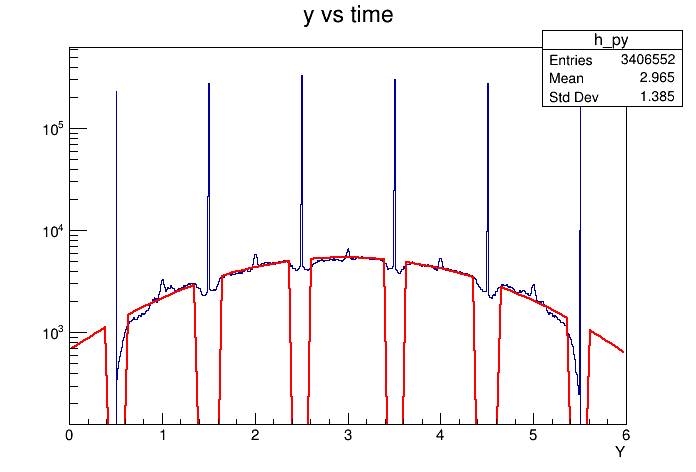

In [153]:
"""
Plot the functions for testing
"""
c = r.TCanvas()
hist = create_hist(chain, "h", 1400, 0, 6000, 1)
proj = hist.ProjectionY("_py", 0, 50)
func = r.TF1("func", reject, 0, 6, 3)
func.SetParameters(1, 2, 1)
#func.Draw()
proj.Draw()
proj.Fit(func, "")
c.SetLogy()
c.Draw()

 FCN=11278.2 FROM MIGRAD    STATUS=CONVERGED     124 CALLS         125 TOTAL
                     EDM=1.07696e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.43082e+03   6.00746e+00   2.34006e-01   4.74088e-05
   2  p1           2.97274e+00   1.48217e-03   7.68148e-05  -9.77292e-01
   3  p2           1.44973e+00   1.60178e-03   6.23519e-05   3.76057e-02


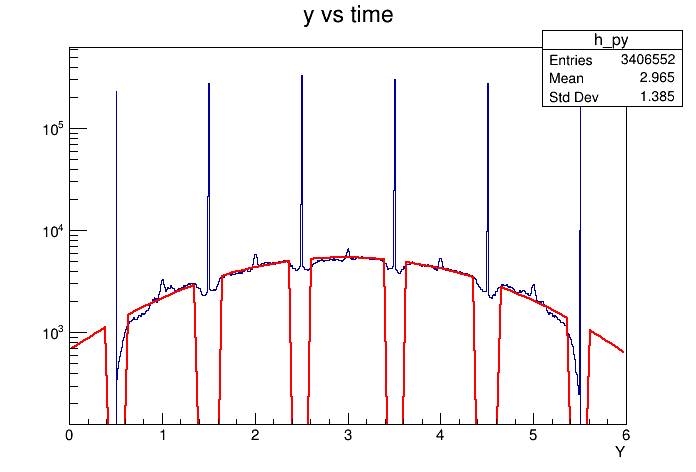

In [165]:
c = r.TCanvas()
proj = hist.ProjectionY("_py", 0, 50)
func = r.TF1("func", reject, 0, 6, 3)
func.SetParameters(1, 2, 1)
#func.Draw()
proj.Draw()
proj.Fit(func, "")
c.SetLogy()
c.Draw()
c.Draw()


In [ ]:
gaus_fit(create_hist(chain, "h"+str(num), XBins, energy_min, energy_max, num), step, no_spikes=True)